In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import json
import glob
import random
from btbench_config import *
from braintreebank_subject import Subject
from btbench_datasets import BrainTreebankSubjectTrialBenchmarkDataset
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'

# all possible pairs of (subject_id, trial_id)
all_subject_trials = [(1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (4, 0), (4, 1), (4, 2), (5, 0), (6, 0), (6, 1), (6, 4), (7, 0), (7, 1), (8, 0), (9, 0), (10, 0), (10, 1)]
# all possible evaluations for now
all_evaluations = ["pitch", "rms", "onset", "speech"]

In [3]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

matlab_xlim = (-108.0278, 108.0278)
matlab_ylim = (-72.9774, 72.9774)

base_path = os.path.join(ROOT_DIR, 'localization')
left_hem_file_name = 'left_hem_clean.png'
right_hem_file_name = 'right_hem_clean.png'
coords_file_name = 'elec_coords_full.csv'
correlations_file = 'lag_correlation.json'

left_hem_img = plt.imread(os.path.join(base_path, left_hem_file_name))
right_hem_img = plt.imread(os.path.join(base_path, right_hem_file_name))
coords_df = pd.read_csv(os.path.join(base_path, coords_file_name))
split_elec_id = coords_df['ID'].str.split('-')
coords_df['Subject'] = [t[0] for t in split_elec_id]
coords_df['Electrode'] = [t[1] for t in split_elec_id]

# Scale Matlab electrode locations to Python format
def scale(x, s, d):
    return -(x - d) * s

x_scale = left_hem_img.shape[1] / (matlab_xlim[1] - matlab_xlim[0])
y_scale_l = left_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

y_scale_r = right_hem_img.shape[0] / (matlab_ylim[1] - matlab_ylim[0])

scaled_coords_df = coords_df.copy()

# scale left hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'X'].apply(lambda x: scale(x, x_scale, matlab_xlim[1]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 1, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 1, 'Y'].apply(lambda x: scale(x, y_scale_l, matlab_ylim[1]))

# scale right hemisphere coordinates
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'X'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'X'].apply(lambda x: -scale(x, y_scale_r, matlab_xlim[0]))
scaled_coords_df.loc[scaled_coords_df['Hemisphere'] == 0, 'Y'] = coords_df.loc[coords_df['Hemisphere'] == 0, 'Y'].apply(lambda x: scale(x, y_scale_r, matlab_ylim[1]))

def plot_hemisphere_axis(electrodes, colors=None, ax=None, hemisphere="left", title=None, vmin=0, vmax=0.1):
    '''
    electrodes is a dict of format {<subject>: [<electrode>]}
    '''
    if colors is None: c = 'white'
    ax.set_aspect('equal')

    if hemisphere=="left":
        ax.imshow(left_hem_img)
    elif hemisphere=="right":
        ax.imshow(right_hem_img)
    
    ax.axis('off')
    assert hemisphere in ["left", "right"]
    hem_index = 1 if hemisphere=="left" else 0

    plot_title = f'{hemisphere} hemisphere'
    if title: plot_title += f' {title}'
   
    all_x, all_y, all_colors = [], [], []
    for s in electrodes:
        for e in electrodes[s]:
            x = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['X'])
            y = list(scaled_coords_df[(scaled_coords_df.Subject == s) & (scaled_coords_df.Electrode == e) & (scaled_coords_df.Hemisphere==hem_index)]['Y'])

            all_x += x
            all_y += y
            all_colors += [colors[e]] * len(x)
    
    all_x = np.array(all_x)
    all_y = np.array(all_y)
    all_colors = np.array(all_colors)
    # Sort points by color value so lower values appear on top
    sort_idx = np.argsort(all_colors)[::-1]
    sc = ax.scatter(all_x[sort_idx], all_y[sort_idx], c=all_colors[sort_idx], vmin=vmin, vmax=vmax, s=100, edgecolors='black', cmap='viridis_r')
    
def plot_hemispheres_separately(electrodes, ax1, ax2, colors=None, vmin=0, vmax=0.1):
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax1, hemisphere="right", vmin=vmin, vmax=vmax)
    plot_hemisphere_axis(electrodes, colors=colors, ax=ax2, hemisphere="left", vmin=vmin, vmax=vmax)

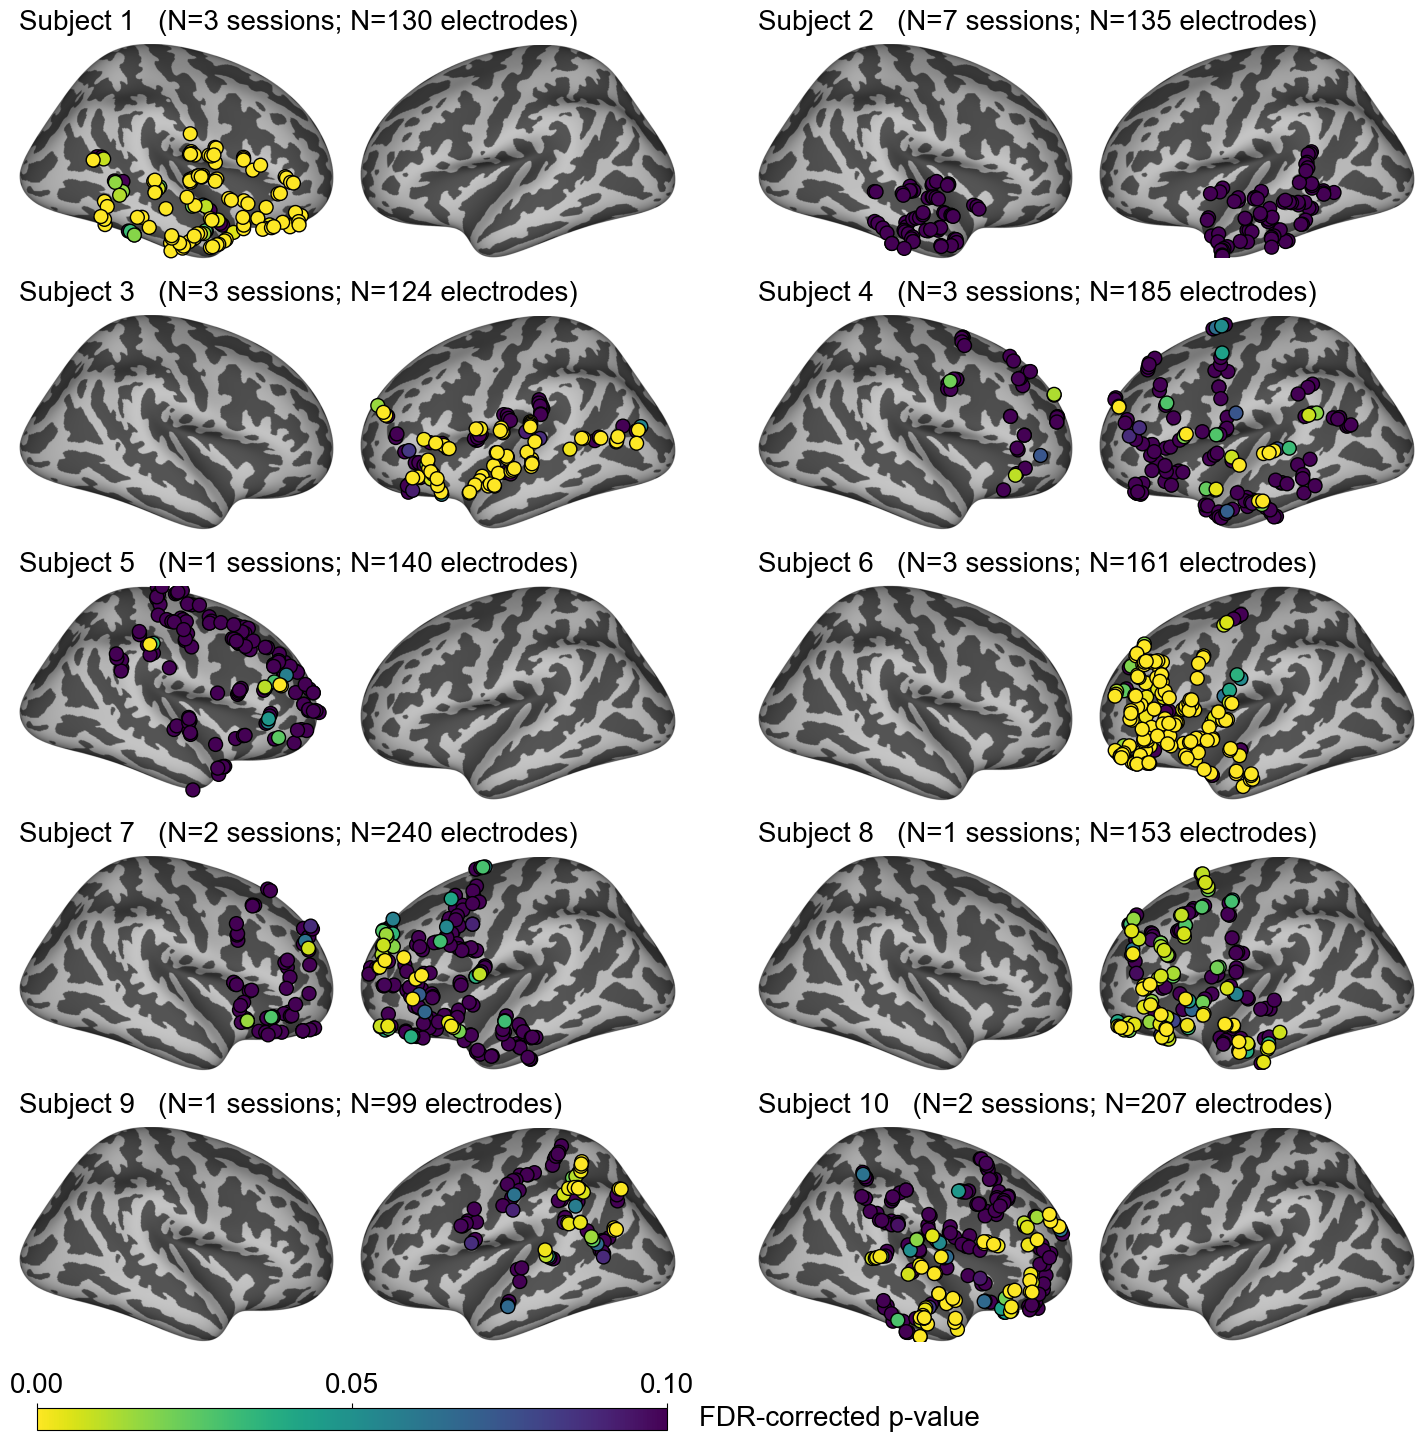

In [4]:
vmin, vmax = 0, 0.1
fig, axes = plt.subplots(6, 5, figsize=(18, 18), 
                        gridspec_kw={'wspace': 0.1, 'hspace': 0.3,
                                   'width_ratios': [1, 1, .1, 1, 1], 'height_ratios': [1, 1, 1, 1, 1, .15]}) 
for subject_id in range(1, 11):
    row = (subject_id - 1) // 2
    if (subject_id - 1) % 2 == 0: col1, col2 = 0, 1
    else: col1, col2 = 3, 4
    subject_class = Subject(subject_id, cache=False)
    n_electrodes = len(subject_class.electrode_labels)
    n_sessions = len([trial_id for (_subject_id, trial_id) in all_subject_trials if _subject_id == subject_id])
    colors = np.ones(n_electrodes)

    if os.path.exists(f"btbench_speech_selectivity/subject{subject_id}_stats.json"):
        subject_metadata = json.load(open(f"btbench_speech_selectivity/subject{subject_id}_stats.json", "r"))
        electrode_p_values = subject_metadata['electrode_p_values']
        electrode_p_values_corrected = subject_metadata['electrode_p_values_corrected']
        fdr_threshold = subject_metadata['fdr_threshold']
        fdr_level = subject_metadata['fdr_level']
        colors = np.array(electrode_p_values_corrected)
    colors = {label: colors[i] for i, label in enumerate(subject_class.electrode_labels)}

    electrodes = {f"sub_{subject_id}": subject_class.electrode_labels}
    plot_hemispheres_separately(electrodes, axes[row, col1], axes[row, col2], colors=colors, vmin=vmin, vmax=vmax)
    # Add text label above each pair of axes
    axes[row, col1].set_title(f'Subject {subject_id}   (N={n_sessions} sessions; N={n_electrodes} electrodes)', 
                              loc='left', fontsize=20, pad=10, weight='bold')
# Remove axes from middle column
for row in range(5):
    axes[row, 2].set_visible(False)
for col in range(5):
    axes[5, col].set_visible(False)

# Add custom colorbar in middle column
cbar_ax = fig.add_subplot(axes[5, 0])
# Adjust the position and width of the colorbar axes
cbar_ax.set_position([cbar_ax.get_position().x0+0.01, 
                      cbar_ax.get_position().y0,
                      cbar_ax.get_position().width * 2,
                      cbar_ax.get_position().height / 1.5])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap='viridis_r')
cbar = plt.colorbar(scalar_mappable, cax=cbar_ax, orientation='horizontal')
cbar.ax.text(0.105, 0.18, 'FDR-corrected p-value', rotation=0, fontsize=20)
cbar.ax.tick_params(labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
cbar.set_ticks(np.arange(0, 0.15, 0.05))
cbar_ax.set_visible(True)

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/language_localizer.pdf', bbox_inches='tight', dpi=300)
